# Do people who are priced out of urban cores face increased commute stress and longer travel times, contributing to greater time poverty?

## Introduction

Homeownership plays a core pillar of the US economy. Since housing prices are one of the largest components of household expenditures in the United States, fluctuations in housing prices significantly affect consumer spending and local economics.

Factors that affect housing prices have been broadly researched and verified. It is widely believed that median income, as a key socioeconomic indicator, plays a significant role in determining housing affordability and demand. Also, previous research states that access to coast view will also have a positive effect on the house price. Dai, Felsenstein, and Grinberger (2023) suggest that the visibility of coastal and natural open spaces contributes significantly to the value of house prices, regardless of their location.  Rush, R., & Bruggink, T. H. (2000) utilizing a hedonic pricing model, research analyzes various factors affecting housing prices, states that houses closer to the beach show higher prices, and underscores the significant premium associated with ocean proximity. 

## Data Cleaning/Loading

In [1]:
pip install -q nbconvert 

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -q pyppeteer 

Note: you may need to restart the kernel to use updated packages.


In [3]:
! pip install -q qeds

In [129]:
!pip install geopandas -qq

In [132]:
import pandas as pd
import geopandas as gpd
import qeds
%matplotlib inline
import requests
from IPython.display import display
import datetime as dt
from shapely.geometry import Point
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as sm
from pandas_datareader import DataReader
import warnings
warnings.filterwarnings("ignore")

In [133]:
pd.set_option("display.max_columns", None)

In [134]:
file_path = "/Users/shenxiner1/Downloads/ECO225/ECO225 Project/Data/housing.csv"
hp = pd.read_csv(file_path)
hp = pd.DataFrame(hp)
hp.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [135]:
file_path = "/Users/shenxiner1/Downloads/ECO225/ECO225 Project/Data/usa_00020.csv.gz"
census_data = pd.read_csv(file_path, compression='gzip')
census_data = pd.DataFrame(census_data)
census_data.head()

,YEAR,SAMPLE,SERIAL,HHWT,CLUSTER,STATEFIP,COUNTYFIP,PUMA,URBAN,STRATA,PUMATYPE,GQ,PERNUM,PERWT,AGE,INCTOT,FTOTINC,INCWAGE,POVERTY,PWPUMA,TRANWORK,TRANTIME,DEPARTS
0,1990,199002,46453,91.0,1990000464532,6,0,100,1,44,50,1,1,91.0,22,860,860,860,13,1,60,1,400
1,1990,199002,46456,78.0,1990000464562,6,0,100,1,48,50,1,1,91.0,37,35000,36248,35000,288,1,10,3,530
2,1990,199002,46456,78.0,1990000464562,6,0,100,1,48,50,1,2,78.0,36,1248,36248,1248,288,1,10,5,855
3,1990,199002,46456,78.0,1990000464562,6,0,100,1,48,50,1,3,91.0,12,9999999,36248,999999,288,0,0,0,0
4,1990,199002,46456,78.0,1990000464562,6,0,100,1,48,50,1,4,91.0,10,9999999,36248,999999,288,0,0,0,0


In [136]:
county_shp = gpd.read_file("/Users/shenxiner1/Downloads/ECO225/ECO225 Project/Data/ipums_puma_1990_5pct/ipums_puma_1990_5pct.shp")
county_shp = county_shp.to_crs(epsg=4326)
county_shp.head()

,GISMATCH,STATEFIP,PUMA,geometry
0,200101,02,00101,"MULTIPOLYGON (((-148.56983 61.4273, -148.54955..."
1,200102,02,00102,"MULTIPOLYGON (((-148.47439 60.9792, -148.49 60..."
2,200200,02,00200,"MULTIPOLYGON (((-135.29933 56.72685, -135.3007..."
3,200300,02,00300,"MULTIPOLYGON (((-172.95819 52.07297, -172.9595..."
4,1500307,15,00307,"MULTIPOLYGON (((-157.74456 21.42878, -157.7449..."


### Create New Columns

In [137]:
hp['median_house_value(in tens of thousandss)'] = hp['median_house_value']/10000 
hp['house-price-to-income ratio']=hp['median_house_value(in tens of thousandss)']/hp['median_income']

In [138]:
def categorize_pumatype(pumatype):
    """
    Categorizes the PUMATYPE variable into broader metropolitan categories.
    
    Parameters:
    pumatype (int): PUMATYPE code.

    Returns:
    str: Categorical label for metropolitan classification.
    """
    if pumatype in [10, 11, 22]:
        return "Central City"
    elif pumatype in [20, 21, 30, 31]:
        return "Suburban (MSA Outside Central City)"
    elif pumatype == 40:
        return "Mixed/Other MSA Status"
    elif pumatype == 50:
        return "Rural (Outside MSA/PMSA)"
    else:
        return "Unknown"

census_data["PUMATYPE_CATEGORY"] = census_data["PUMATYPE"].apply(categorize_pumatype)

In [139]:
category_mapping = {
    10: 'Vehicle',  # Auto, truck, or van
    20: 'Vehicle',  # Motorcycle
    31: 'Public Transport',  # Bus
    32: 'Public Transport',  # Bus or trolley bus
    36: 'Public Transport',  # Subway or elevated
    50: 'Public Transport',  # Bicycle
    60: 'Public Transport',  # Walked only
    80: 'Public Transport'   # Worked at home
}
census_data['Work Transportation'] = census_data['TRANWORK'].map(category_mapping)

In [140]:
census_data["tFTOTINC"] = census_data["FTOTINC"]/1000
census_data["tINCTOT"] = census_data["INCTOT"]/1000

### Chekcing Missing Value

In [167]:
hp.isnull().sum()
hp = hp.dropna()

In [168]:
census_data.isnull().sum()
census_data = census_data.dropna()

In [169]:
census_data = census_data[census_data['PWPUMA'] != 0]

### Merge Dataset

In [170]:
hp['geometry'] = hp.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
hp.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_house_value(in tens of thousandss),house-price-to-income ratio,geometry
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,45.26,5.436506,POINT (-122.23 37.88)
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,35.85,4.318549,POINT (-122.22 37.86)
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,35.21,4.851600,POINT (-122.24 37.85)
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,34.13,6.048094,POINT (-122.25 37.85)
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,34.22,8.897093,POINT (-122.25 37.85)


In [171]:
data_gdf = gpd.GeoDataFrame(hp, geometry='geometry', crs="EPSG:4326")
result = gpd.sjoin(data_gdf, county_shp, how='left', predicate='within')

In [172]:
result['PWPUMA'] = result['PUMA'].astype(str).str[:3]
puma_avg = result.groupby(['PUMA', 'PWPUMA','ocean_proximity'])[['median_house_value', 'median_income', 'total_rooms', 'total_bedrooms', 'households', 'population', 'house-price-to-income ratio']].mean()

In [173]:
puma_avg.reset_index(inplace=True)
puma_avg['PWPUMA'] = puma_avg['PWPUMA'].astype(int)

In [174]:
puma_avg.head()

,PUMA,PWPUMA,ocean_proximity,median_house_value,median_income,total_rooms,total_bedrooms,households,population,house-price-to-income ratio
0,00100,1,<1H OCEAN,134700.000000,3.049400,1692.000000,358.500000,286.000000,701.500000,4.435963
1,00100,1,INLAND,68860.869565,2.354145,2447.463768,495.159420,415.275362,1129.275362,3.023662
2,00100,1,NEAR OCEAN,86630.000000,2.336700,2909.800000,597.600000,534.900000,1663.500000,3.778784
3,00200,2,<1H OCEAN,82066.666667,2.400613,2025.966667,427.866667,364.000000,968.900000,3.563726
4,00200,2,INLAND,80450.000000,1.934750,1789.500000,434.500000,236.500000,631.500000,4.192458


In [175]:
resultmerge = pd.merge(census_data,puma_avg, on="PWPUMA",how="left")

In [176]:
pd.set_option("display.max_columns", None) 
resultmerge.head()

,YEAR,SAMPLE,SERIAL,HHWT,CLUSTER,STATEFIP,COUNTYFIP,PUMA_x,URBAN,STRATA,PUMATYPE,GQ,PERNUM,PERWT,AGE,INCTOT,FTOTINC,INCWAGE,POVERTY,PWPUMA,TRANWORK,TRANTIME,DEPARTS,PUMATYPE_CATEGORY,Work Transportation,tFTOTINC,tINCTOT,PUMA_y,ocean_proximity,median_house_value,median_income,total_rooms,total_bedrooms,households,population,house-price-to-income ratio
0,1990,199002,46453,91.0,1990000464532,6,0,100,1,44,50,1,1,91.0,22,860,860,860,13,1,60,1,400,Rural (Outside MSA/PMSA),Public Transport,0.860,0.86,00100,<1H OCEAN,134700.000000,3.049400,1692.000000,358.50000,286.000000,701.500000,4.435963
1,1990,199002,46453,91.0,1990000464532,6,0,100,1,44,50,1,1,91.0,22,860,860,860,13,1,60,1,400,Rural (Outside MSA/PMSA),Public Transport,0.860,0.86,00100,INLAND,68860.869565,2.354145,2447.463768,495.15942,415.275362,1129.275362,3.023662
2,1990,199002,46453,91.0,1990000464532,6,0,100,1,44,50,1,1,91.0,22,860,860,860,13,1,60,1,400,Rural (Outside MSA/PMSA),Public Transport,0.860,0.86,00100,NEAR OCEAN,86630.000000,2.336700,2909.800000,597.60000,534.900000,1663.500000,3.778784
3,1990,199002,46456,78.0,1990000464562,6,0,100,1,48,50,1,1,91.0,37,35000,36248,35000,288,1,10,3,530,Rural (Outside MSA/PMSA),Vehicle,36.248,35.00,00100,<1H OCEAN,134700.000000,3.049400,1692.000000,358.50000,286.000000,701.500000,4.435963
4,1990,199002,46456,78.0,1990000464562,6,0,100,1,48,50,1,1,91.0,37,35000,36248,35000,288,1,10,3,530,Rural (Outside MSA/PMSA),Vehicle,36.248,35.00,00100,INLAND,68860.869565,2.354145,2447.463768,495.15942,415.275362,1129.275362,3.023662


In [177]:
resultmerge.isnull().sum()

YEAR                               0
SAMPLE                             0
SERIAL                             0
HHWT                               0
CLUSTER                            0
STATEFIP                           0
COUNTYFIP                          0
PUMA_x                             0
URBAN                              0
STRATA                             0
PUMATYPE                           0
GQ                                 0
PERNUM                             0
PERWT                              0
AGE                                0
INCTOT                             0
FTOTINC                            0
INCWAGE                            0
POVERTY                            0
PWPUMA                             0
TRANWORK                           0
TRANTIME                           0
DEPARTS                            0
PUMATYPE_CATEGORY                  0
Work Transportation                0
tFTOTINC                           0
tINCTOT                            0
P

In [179]:
resultmerge = resultmerge.dropna()

### Filter Columns

In [180]:
columns_to_keep = [
    "PUMA_x", "PUMATYPE", "AGE", "INCTOT", "FTOTINC","tINCTOT","tFTOTINC","INCWAGE", 
    "PWPUMA","TRANTIME", "DEPARTS", "Work Transportation","PUMATYPE_CATEGORY","median_house_value",
    "median_income", "house-price-to-income ratio"
]
resultmerge = resultmerge[columns_to_keep]
resultmerge = pd.DataFrame(resultmerge)
resultmerge.head()

,PUMA_x,PUMATYPE,AGE,INCTOT,FTOTINC,tINCTOT,tFTOTINC,INCWAGE,PWPUMA,TRANTIME,DEPARTS,Work Transportation,PUMATYPE_CATEGORY,median_house_value,median_income,house-price-to-income ratio
0,100,50,22,860,860,0.86,0.860,860,1,1,400,Public Transport,Rural (Outside MSA/PMSA),134700.000000,3.049400,4.435963
1,100,50,22,860,860,0.86,0.860,860,1,1,400,Public Transport,Rural (Outside MSA/PMSA),68860.869565,2.354145,3.023662
2,100,50,22,860,860,0.86,0.860,860,1,1,400,Public Transport,Rural (Outside MSA/PMSA),86630.000000,2.336700,3.778784
3,100,50,37,35000,36248,35.00,36.248,35000,1,3,530,Vehicle,Rural (Outside MSA/PMSA),134700.000000,3.049400,4.435963
4,100,50,37,35000,36248,35.00,36.248,35000,1,3,530,Vehicle,Rural (Outside MSA/PMSA),68860.869565,2.354145,3.023662


## Summary Statistics Tables

In [181]:
resultmerge['affordable'] = resultmerge['house-price-to-income ratio'].apply(
    lambda x: 'Not Affordable' if x > 5 else 'Affordable'
)

In [182]:
variables_of_interest = ["AGE", "tINCTOT", "tFTOTINC","median_house_value", 
                         "median_income", "house-price-to-income ratio",  
                         "TRANTIME", "DEPARTS"]

resultmerge[variables_of_interest].describe()


,AGE,tINCTOT,tFTOTINC,median_house_value,median_income,house-price-to-income ratio,TRANTIME,DEPARTS
count,1.520318e+06,1.520318e+06,1.520318e+06,1.520318e+06,1.520318e+06,1.520318e+06,1.520318e+06,1.520318e+06
mean,3.754004e+01,2.837878e+01,1.658813e+02,2.488144e+05,4.306292e+00,6.265490e+00,2.541011e+01,7.883314e+02
std,1.289875e+01,2.998151e+01,1.048863e+03,9.757895e+04,1.420105e+00,1.997580e+00,1.908488e+01,3.610113e+02
min,1.600000e+01,-1.749800e+01,-1.999800e+01,6.886087e+04,1.333300e+00,2.280897e+00,0.000000e+00,0.000000e+00
25%,2.700000e+01,1.013200e+01,2.687200e+01,1.796354e+05,3.355094e+00,4.860834e+00,1.000000e+01,6.300000e+02
50%,3.600000e+01,2.105000e+01,4.581000e+01,2.285000e+05,4.008616e+00,5.851257e+00,2.000000e+01,7.300000e+02
75%,4.600000e+01,3.600000e+01,7.081500e+01,3.116099e+05,5.170008e+00,7.022845e+00,3.000000e+01,8.300000e+02
max,9.000000e+01,3.956340e+02,9.999999e+03,5.000010e+05,1.122817e+01,1.554171e+01,9.900000e+01,2.400000e+03


In [183]:
categorical_vars = ["Work Transportation", "PUMATYPE_CATEGORY"]
resultmerge[categorical_vars].describe()

,Work Transportation,PUMATYPE_CATEGORY
count,1520318,1520318
unique,2,3
top,Vehicle,Suburban (MSA Outside Central City)
freq,1334528,891219


In [184]:
pd.set_option("display.max_rows", None) 
variables_of_interest = ["AGE", "tINCTOT", "tFTOTINC","median_house_value", 
                         "median_income", "house-price-to-income ratio",  
                         "TRANTIME", "DEPARTS","affordable",'PUMATYPE_CATEGORY']

resultmerge[variables_of_interest].groupby(['affordable','PUMATYPE_CATEGORY']).describe().transpose()

affordable                            Affordable                           \
PUMATYPE_CATEGORY                   Central City Rural (Outside MSA/PMSA)   
AGE                         count  150634.000000              7191.000000   
                            mean       37.018037                39.625365   
                            std        12.899066                13.306334   
                            min        16.000000                16.000000   
                            25%        27.000000                30.000000   
                            50%        35.000000                38.000000   
                            75%        45.000000                48.000000   
                            max        90.000000                89.000000   
tINCTOT                     count  150634.000000              7191.000000   
                            mean       26.795460                21.848338   
                            std        28.813395                19.910651   
                            min       -17.498000                -9.999000   
                            25%        10.000000                 9.000000   
                            50%        20.000000                17.000000   
                            75%        34.500000                30.000000   
                            max       377.634000               263.479000   
tFTOTINC                    count  150634.000000              7191.000000   
                            mean      269.024062               170.173079   
                            std      1459.618325              1131.706855   
                            min       -10.549000                -9.999000   
                            25%        24.000000                21.465000   
                            50%        42.000000                35.850000   
                            75%        67.103000                53.000000   
                            max      9999.999000              9999.999000   
median_house_value          count  150634.000000              7191.000000   
                            mean   178318.683880            104620.354350   
                            std     57035.470794             34261.083837   
                            min     68860.869565             68860.869565   
                            25%    148058.000000             80544.274809   
                            50%    164254.568182             91950.588235   
                            75%    217848.607477            121953.030303   
                            max    483372.142857            483372.142857   
median_income               count  150634.000000              7191.000000   
                            mean        4.103546                 2.705044   
                            std         1.112320                 0.636212   
                            min         1.934750                 1.934750   
                            25%         3.418387                 2.354145   
                            50%         3.799690                 2.495711   
                            75%         4.701875                 2.922445   
                            max        11.228171                11.228171   
house-price-to-income ratio count  150634.000000              7191.000000   
                            mean        4.458164                 4.017776   
                            std         0.473094                 0.522154   
                            min         2.280897                 2.280897   
                            25%         4.241045                 3.563726   
                            50%         4.644344                 4.192458   
                            75%         4.785419                 4.409855   
                            max         4.990394                 4.989256   
TRANTIME                    count  150634.000000              7191.000000   
                            mean       24.138508                18.998470

In [185]:
variables_of_interest = ["Work Transportation", "PUMATYPE_CATEGORY","affordable"]
resultmerge[variables_of_interest].groupby(['affordable',"PUMATYPE_CATEGORY"]).describe()

Work Transportation         \
                                                                 count unique   
affordable     PUMATYPE_CATEGORY                                                
Affordable     Central City                                     150634      2   
               Rural (Outside MSA/PMSA)                           7191      2   
               Suburban (MSA Outside Central City)              275890      2   
Not Affordable Central City                                     469364      2   
               Rural (Outside MSA/PMSA)                           1910      2   
               Suburban (MSA Outside Central City)              615329      2   

                                                                     
                                                        top    freq  
affordable     PUMATYPE_CATEGORY                                     
Affordable     Central City                         Vehicle  131882  
               Rural (Outside MSA/PMSA)             Vehicle    6348  
               Suburban (MSA Outside Central City)  Vehicle  250681  
Not Affordable Central City                         Vehicle  384712  
               Rural (Outside MSA/PMSA)             Vehicle    1727  
               Suburban (MSA Outside Central City)  Vehicle  559178

## Plots, Histograms, Figures

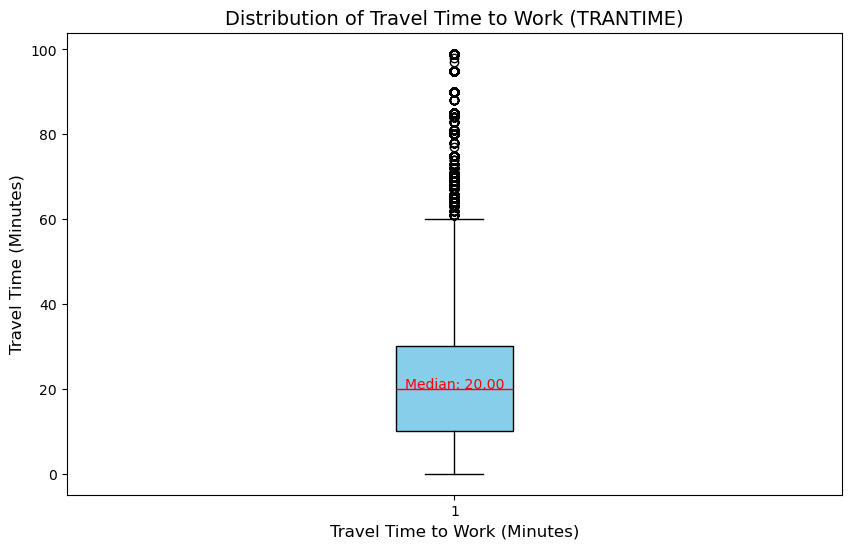

In [186]:
plt.figure(figsize=(10, 6))
plt.boxplot(resultmerge['TRANTIME'], patch_artist=True, boxprops=dict(facecolor='skyblue', color='black'), 
            medianprops=dict(color='red'))
median_value = resultmerge['TRANTIME'].median()
plt.text(1, median_value, f'Median: {median_value:.2f}', horizontalalignment='center', fontsize=10, color='red')

plt.xlabel('Travel Time to Work (Minutes)', fontsize=12)
plt.ylabel('Travel Time (Minutes)', fontsize=12)
plt.title('Distribution of Travel Time to Work (TRANTIME)', fontsize=14)

plt.show()

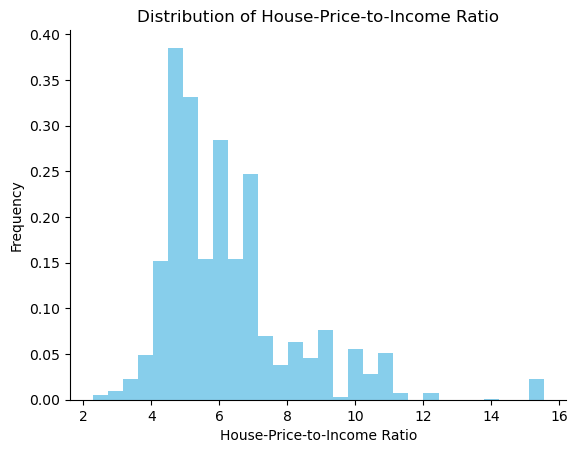

In [187]:
fig, ax = plt.subplots()
resultmerge.plot(
    kind="hist", y="house-price-to-income ratio", color='skyblue',
    bins=30, legend=False, density=True, ax=ax
)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('House-Price-to-Income Ratio')
plt.ylabel('Frequency')
plt.title('Distribution of House-Price-to-Income Ratio')
plt.show()

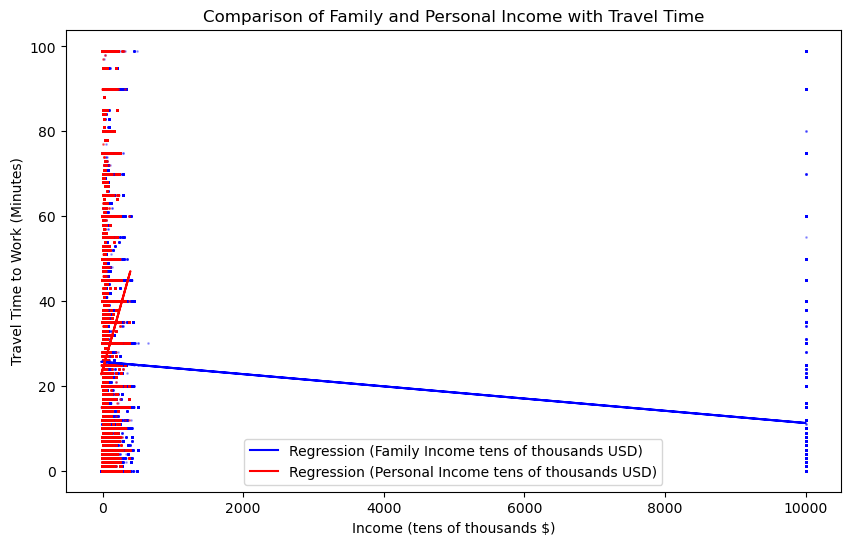

In [188]:
from sklearn.linear_model import LinearRegression
def scatter_plot_income_vs_travel_time(df, ax, color1, color2, alpha1=0.3, alpha2=0.5):
    """
    This function creates a scatter plot of family income (FTOTINC) vs. personal income (INCTOT)
    against travel time (TRANTIME) and fits a linear regression line for each.
    
    Parameters:
    df (DataFrame): The dataframe containing the data.
    ax (matplotlib.axes._subplots.AxesSubplot): The axis on which to plot the data.
    color1 (str): Color for family income scatter points and regression line.
    color2 (str): Color for personal income scatter points and regression line.
    alpha1 (float): Transparency for family income scatter plot.
    alpha2 (float): Transparency for personal income scatter plot.
    """
    
    df.plot(kind="scatter", x="tFTOTINC", y="TRANTIME", ax=ax, color=color1, alpha=alpha1, s=1)

    # Scatter plot for Personal Income (INCTOT) vs. Travel Time
    df.plot(kind="scatter", x="tINCTOT", y="TRANTIME", ax=ax, color=color2, alpha=alpha2, s=1)

    lr1 = LinearRegression()
    X1 = df["tFTOTINC"].values.reshape(-1, 1)
    y1 = df["TRANTIME"].values.reshape(-1, 1)
    lr1.fit(X1, y1)
    y_pred1 = lr1.predict(X1)
    ax.plot(X1, y_pred1, color=color1, label="Regression (Family Income tens of thousands USD)")

    # Linear regression for Personal Income (INCTOT)
    lr2 = LinearRegression()
    X2 = df["tINCTOT"].values.reshape(-1, 1)
    y2 = df["TRANTIME"].values.reshape(-1, 1)
    lr2.fit(X2, y2)
    y_pred2 = lr2.predict(X2)
    ax.plot(X2, y_pred2, color=color2, label="Regression (Personal Income tens of thousands USD)")

    # Labels and title
    ax.set_xlabel('Income (tens of thousands $)')
    ax.set_ylabel('Travel Time to Work (Minutes)')
    ax.set_title('Comparison of Family and Personal Income with Travel Time')

    ax.legend()
    
    return ax

fig, ax = plt.subplots(figsize=(10, 6))
scatter_plot_income_vs_travel_time(resultmerge, ax, "blue", "red")
plt.show()

In [191]:
from sklearn.linear_model import LinearRegression

def scatter_plot_with_two_transportation_types(df, trans1, trans2, ax, color1, color2,alpha1=0.3, alpha2=0.5):
    """
    This function creates a scatter plot of house-price-to-income ratio vs. travel time
    for two transportation types, and fits a linear regression line for each type.
    
    Parameters:
    df (DataFrame): The dataframe containing the data.
    trans1 (str): The first type of transportation (used to filter the dataframe).
    trans2 (str): The second type of transportation (used to filter the dataframe).
    ax (matplotlib axes object): The axis on which to plot the data.
    color1 (str): Color for the first transportation type's scatter points and regression line.
    color2 (str): Color for the second transportation type's scatter points and regression line.
    """
    resultmerge_trans1 = df[df['Work Transportation'] == trans1]
    resultmerge_trans2 = df[df['Work Transportation'] == trans2]
    resultmerge_trans1.plot(kind="scatter", x="house-price-to-income ratio", y="TRANTIME", ax=ax, color=color1, alpha=alpha1,s=1)
    resultmerge_trans2.plot(kind="scatter", x="house-price-to-income ratio", y="TRANTIME", ax=ax, color=color2,alpha=alpha2,s=1)
    
    
    lr1 = LinearRegression()
    X1 = resultmerge_trans1["house-price-to-income ratio"].values.reshape(-1, 1)
    y1 = resultmerge_trans1["TRANTIME"].values.reshape(-1, 1)
    lr1.fit(X1, y1)
    y_pred1 = lr1.predict(X1)
    ax.plot(X1, y_pred1, color=color1)  
    lr2 = LinearRegression()
    X2 = resultmerge_trans2["house-price-to-income ratio"].values.reshape(-1, 1)
    y2 = resultmerge_trans2["TRANTIME"].values.reshape(-1, 1)
    lr2.fit(X2, y2)
    y_pred2 = lr2.predict(X2)
    ax.plot(X2, y_pred2, color=color2)

    ax.set_xlabel('House-price-to-income ratio at Working Place')
    ax.set_ylabel('Travel Time to Work (Minutes)')
    ax.set_title(f'Relationship between House Price-to-Income Ratio and Travel Time for {trans1} and {trans2}')
    ax.annotate("Public Transport", (14.5,40), color=color1)
    ax.annotate("Vehicle", (14.5, 20), color=color2)

    return ax


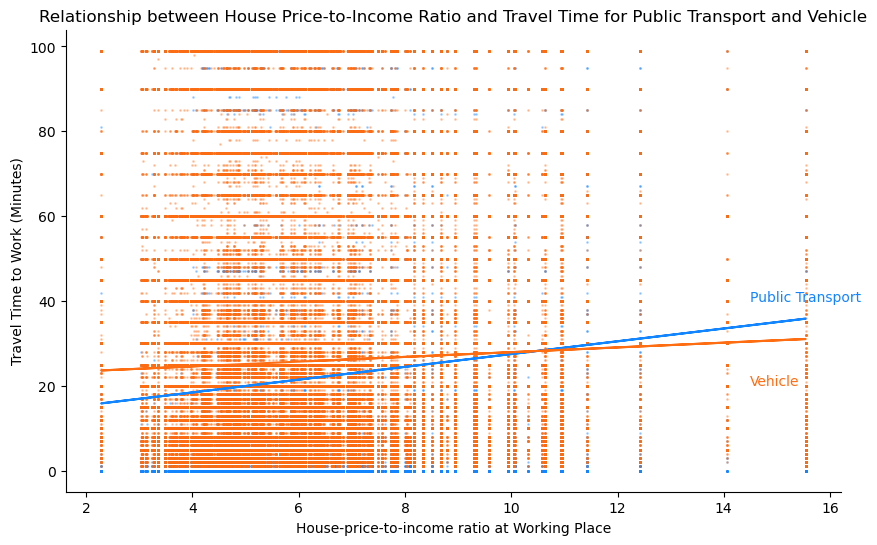

In [192]:
fig, ax = plt.subplots(figsize=(10, 6))
scatter_plot_with_two_transportation_types(resultmerge, 'Public Transport', 'Vehicle', ax, '#1385ff', '#ff6d13',0.3,0.3)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

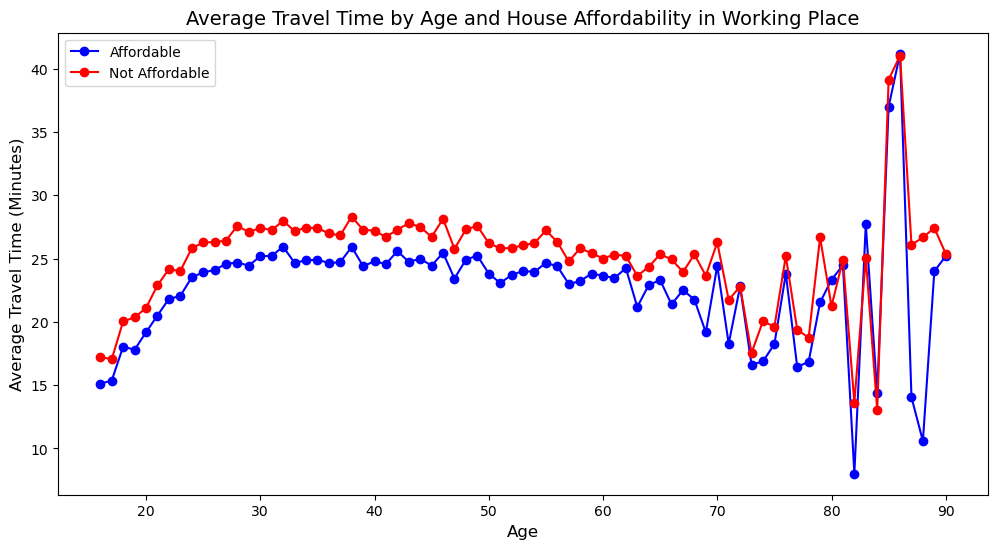

In [193]:

avg_trantime_by_age = resultmerge.groupby(['AGE', 'affordable'])['TRANTIME'].mean().reset_index()

plt.figure(figsize=(12, 6))

affordable_data = avg_trantime_by_age[avg_trantime_by_age['affordable'] == 'Affordable']
plt.plot(affordable_data['AGE'], affordable_data['TRANTIME'], label='Affordable', color='blue', marker='o')

not_affordable_data = avg_trantime_by_age[avg_trantime_by_age['affordable'] == 'Not Affordable']
plt.plot(not_affordable_data['AGE'], not_affordable_data['TRANTIME'], label='Not Affordable', color='red', marker='o')

plt.title('Average Travel Time by Age and House Affordability in Working Place', fontsize=14)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Average Travel Time (Minutes)', fontsize=12)

plt.legend()
plt.show()

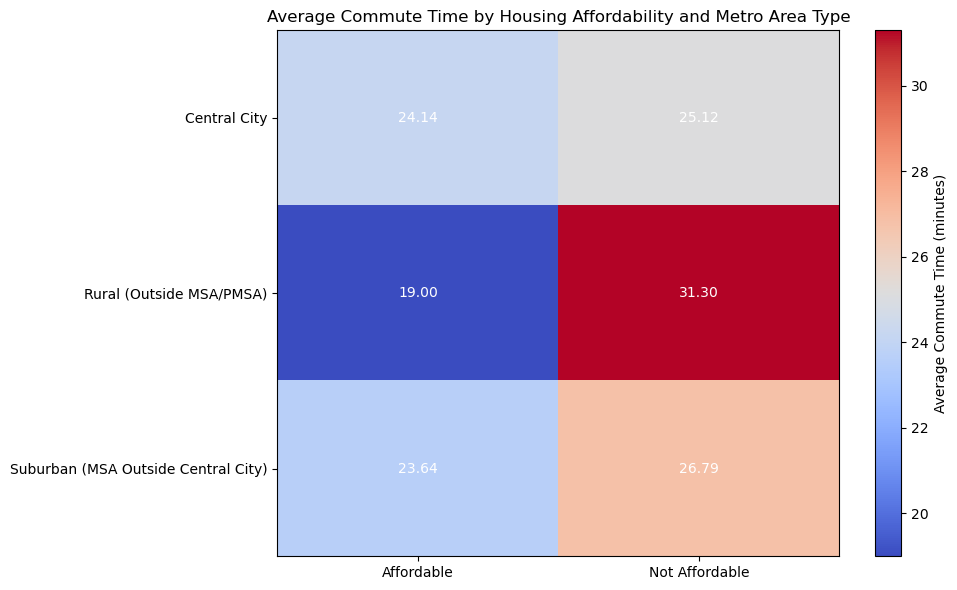

In [194]:
pivot_data = resultmerge.pivot_table(values='TRANTIME', 
                                        index='PUMATYPE_CATEGORY', 
                                        columns='affordable', 
                                        aggfunc='mean')


fig, ax = plt.subplots(figsize=(10, 6))  
cax = ax.imshow(pivot_data, cmap='coolwarm', aspect='auto')


ax.set_xticks(range(len(pivot_data.columns)), labels=pivot_data.columns)
ax.set_yticks(range(len(pivot_data.index)), labels=pivot_data.index)

for i in range(len(pivot_data.index)):
    for j in range(len(pivot_data.columns)):
        ax.text(j, i, f"{pivot_data.iloc[i, j]:.2f}",
                ha="center", va="center", color="w")

ax.set_title('Average Commute Time by Housing Affordability and Metro Area Type')



cbar = fig.colorbar(cax, ax=ax)
cbar.set_label('Average Commute Time (minutes)')

fig.tight_layout()
plt.show()

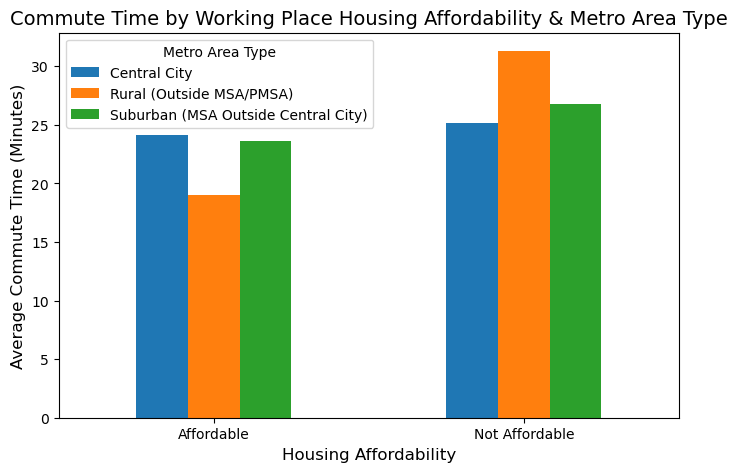

In [195]:
commute_time_by_affordability = resultmerge.groupby(["affordable", "PUMATYPE_CATEGORY"])["TRANTIME"].mean().unstack()

fig, ax = plt.subplots(figsize=(8, 5))
commute_time_by_affordability.plot(kind="bar", ax=ax, color=["#1f77b4", "#ff7f0e", "#2ca02c"])

ax.set_xlabel("Housing Affordability", fontsize=12)
ax.set_ylabel("Average Commute Time (Minutes)", fontsize=12)
ax.set_title("Commute Time by Working Place Housing Affordability & Metro Area Type", fontsize=14)
ax.legend(title="Metro Area Type", fontsize=10)
plt.xticks(rotation=0)

plt.show()

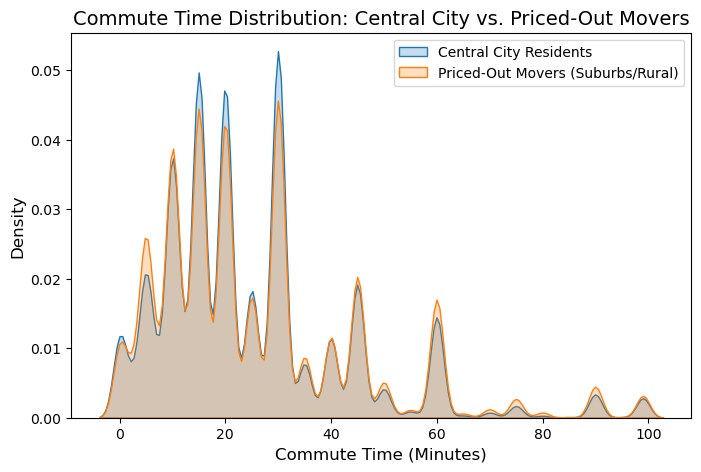

In [196]:
import seaborn as sns
central_city = resultmerge[resultmerge["PUMATYPE_CATEGORY"] == "Central City"]
priced_out = resultmerge[resultmerge["PUMATYPE_CATEGORY"] != "Central City"]

fig, ax = plt.subplots(figsize=(8, 5))
sns.kdeplot(central_city["TRANTIME"], label="Central City Residents", shade=True, color="#1f77b4", ax=ax)
sns.kdeplot(priced_out["TRANTIME"], label="Priced-Out Movers (Suburbs/Rural)", shade=True, color="#ff7f0e", ax=ax)

ax.set_xlabel("Commute Time (Minutes)", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.set_title("Commute Time Distribution: Central City vs. Priced-Out Movers", fontsize=14)
ax.legend(fontsize=10)

plt.show()

In [197]:
def categorize_departure_time(departs):
    """
    Categorizes the DEPARTS variable into five departure time groups.
    
    Parameters:
    departs (int): The 4-digit DEPARTS value.

    Returns:
    str: Categorical label for departure time.
    """
    if departs == 0 or pd.isna(departs):  
        return "N/A"
    elif 1 <= departs <= 559:
        return "Very Early (Midnight - 6 AM)"
    elif 600 <= departs <= 859:
        return "Early Morning (6 AM - 9 AM)"
    elif 900 <= departs <= 1159:
        return "Mid-Morning (9 AM - 12 PM)"
    elif 1200 <= departs <= 1659:
        return "Afternoon (12 PM - 5 PM)"
    else:
        return "Evening/Night (5 PM - Midnight)"

resultmerge["DEPARTS_CATEGORY"] = resultmerge["DEPARTS"].apply(categorize_departure_time)
category_order = [
    "Very Early (Midnight - 6 AM)",
    "Early Morning (6 AM - 9 AM)",
    "Mid-Morning (9 AM - 12 PM)",
    "Afternoon (12 PM - 5 PM)",
    "Evening/Night (5 PM - Midnight)",

]
resultmerge_filtered = resultmerge[resultmerge["DEPARTS"] != 0]
resultmerge_filtered["DEPARTS_CATEGORY"] = pd.Categorical(resultmerge_filtered["DEPARTS_CATEGORY"], categories=category_order, ordered=True)

resultmerge_sorted = resultmerge_filtered.sort_values("DEPARTS_CATEGORY")


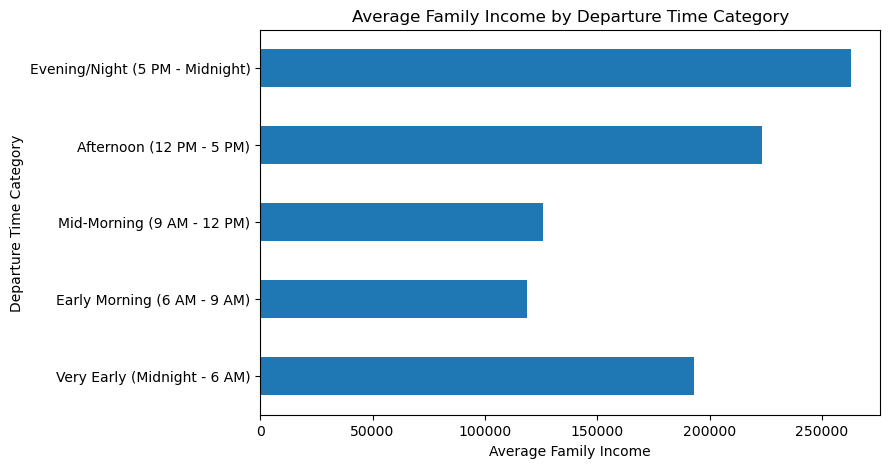

In [198]:
resultmerge_filtered = resultmerge_sorted[resultmerge_sorted["DEPARTS"] != 0]
income_by_departure = resultmerge_filtered.groupby("DEPARTS_CATEGORY")["FTOTINC"].mean()
fig, ax = plt.subplots(figsize=(8, 5))
income_by_departure.plot(kind="barh", ax=ax)

ax.set_ylabel("Departure Time Category")
ax.set_xlabel("Average Family Income")
ax.set_title("Average Family Income by Departure Time Category")
plt.show()

## Conclusion

# Reference